In [1]:
import pandas as pd
import json

d4j_perturbed_bugs = { "Chart-26", "Cli-1" , "Closure-106" , "Codec-1" , 
                  "Collections-25" , "Compress-1" , "Csv-1" , "Gson-1" ,
                  "JacksonCore-1" , "JacksonDatabind-1" , "JacksonXml-1" ,
                  "Jsoup-1" , "JxPath-1" , "Lang-65" , "Math-106" ,
                  "Mockito-28" , "Time-27"
                 }

bears_perturbed_bugs = {"Bears-140","Bears-1","Bears-194","Bears-196","Bears-213",
                        "Bears-205","Bears-232","Bears-204","Bears-98","Bears-251",
                        "Bears-153","Bears-180","Bears-165","Bears-207","Bears-198",
                        "Bears-186","Bears-210","Bears-190","Bears-241","Bears-166",
                        "Bears-199","Bears-200","Bears-234","Bears-240","Bears-250",
                        "Bears-223","Bears-144","Bears-212","Bears-214","Bears-169",
                        "Bears-242","Bears-246","Bears-156","Bears-84","Bears-238",
                        "Bears-157","Bears-202","Bears-231","Bears-243","Bears-247",
                        "Bears-233","Bears-239","Bears-220","Bears-245","Bears-158",
                        "Bears-209","Bears-188","Bears-229","Bears-193","Bears-230",
                        "Bears-211","Bears-221","Bears-222","Bears-228","Bears-248",
                        "Bears-201","Bears-224","Bears-176","Bears-27","Bears-227",
                        "Bears-249","Bears-142","Bears-225","Bears-159","Bears-170",
                        "Bears-197","Bears-226","Bears-184","Bears-177","Bears-149",
                        "Bears-206","Bears-155"}

def read_eval_d4j(path):
    df = pd.read_json(path, orient="index")
    df = df[~df.index.isin(d4j_perturbed_bugs)]
    return df

def read_eval_bears(path):
    df = pd.read_json(path, orient="index")
    df = df[~df.index.isin(bears_perturbed_bugs)]
    return df

In [2]:
def get_number_compile(df):
    count = 0
    all_count = 0
    for index, row in df.iterrows():
        pass
#        for fix in row.fixes:
#            all_count += 1
#            if fix["comp_pass"] and row.buggy_line != row.fixed_line:
#                count += 1
    return "%d / %d (%.2f%%)" % (count, all_count, count/all_count*100)

In [3]:
def get_number_fixed(df):
    count = 0
    for index, row in df.iterrows():
        all_fixed = []
        for hunk in row.hunks:
            fixed = False
            for i, fix in enumerate(row.hunks[hunk]["patches"]):
                if fix["identical"]:
                    fixed = True
                    break
            all_fixed += [fixed]
        if True in all_fixed and not False in all_fixed:
            count += 1
    return "%d / %d (%.2f%%)" % (count, len(df), count/len(df)*100)

In [4]:
def get_fixed(df):
    result = []
    for index, row in df.iterrows():
        all_fixed = []
        for hunk in row.hunks:
            fixed = False
            for i, fix in enumerate(row.hunks[hunk]["patches"]):
                if fix["identical"]:
                    fixed = True
                    break
            all_fixed += [fixed]
        if True in all_fixed and not False in all_fixed:
            result += [index]
    return result

In [5]:
def get_table_entry(beam_width, critic, round_, tbb, tbs, tdb, tds, cb, tb, cd, td):
    return {"Hyper Parameters": {
                "" :   { "Beam Width" : beam_width }
            },
            "Training": {
                "Bears" : {"BugLab" : tbb, "SelfAPR": tbs},
                "Defects4J" : {"BugLab" : tdb, "SelfAPR": tds},
                "Critic" : { "" : critic },
                "Round" : { "" : round_ }
            },
            "Testing":{
                "Bears Compile" : { "" : cb },
                "Bears Test Pass" : { "" : tb },
                "Defects4J Compile" : { "" : cd},
                "Defects4J Tests Pass" : { "" : td},
            }
       }

{'Math', 'Jsoup', 'Cli', 'Closure', 'Csv', ' Closure', 'Gson', ' Math', 'Chart', 'Codec', 'Lang', 'JacksonDatabind', 'Mockito', 'Compress', 'Collections', 'JacksonCore', ' Jsoup', 'Time', 'JxPath'}
{'Chart': {1, 4, 7, 8, 9, 11, 14, 20, 24}, 'Math': {32, 98, 5, 70, 72, 104, 75, 77, 46, 79, 80, 49, 50, 82, 85, 22, 57, 30}, 'Compress': {33, 4, 14, 19, 27, 30, 31}, 'JacksonDatabind': {99, 76, 46, 47, 49, 17, 57, 27}, 'Jsoup': {41, 43, 18, 85, 55, 24, 62}, 'Closure': {6, 13, 18, 30, 31, 38, 40, 168, 46, 57, 62, 70, 73, 86, 92, 102, 104, 113, 118, 126}, ' Jsoup': {49, 47}, 'Mockito': {34, 5, 8, 11, 26, 29}, 'Lang': {33, 4, 6, 8, 10, 43, 51, 21, 55, 57, 26, 59}, 'Codec': {17, 2, 3, 7}, 'JacksonCore': {25, 19, 5}, 'Csv': {9, 11}, 'Time': {19, 4}, 'Cli': {5, 8, 17, 18, 25, 27, 28}, 'Collections': {26}, ' Math': {41}, 'JxPath': {10}, 'Gson': {6}, ' Closure': {11}}
Fixed by SelfAPR only: {'Chart-24', 'Math-80', 'Chart-20', 'Compress-4', 'Compress-30', 'JacksonDatabind-49', 'Math-70', 'Jsoup-85', 

,Perturb Actions,Repair Actions,No. bugs,Repaired Bugs,Intersection,Intersection Repaired Bugs
0,P1 Replace type,Replace type,3,"Math-30,Math-79,Math-57",3,"{Math-30, Math-57, Math-79}"
1,P2 Replace operator,Replace operator,11,"Chart-1,Closure-62,Closure-73,Compress-19,Jack...",2,"{Chart-1, JacksonCore-25}"
2,P3 replace literal,Replace literal,14,"Closure-168,Closure-70,Closure-86,Codec-7,Coll...",3,"{Math-22, Closure-70, Closure-86}"
3,P4 replace constructor,replace constructor,1,Lang-26,0,{}
4,P5 replace variable,Replace variable,14,"Chart-11,Chart-20,Chart-7,Chart-8,Time-4,Jacks...",1,{Math-98}
5,P6 replace condition expression,Replace condition expression,16,"Closure-113,Closure-18,Closure-57,Mockito-29,M...",2,"{Math-46, Closure-113}"
6,P7 replace invocation,replace invocation,11,"Closure-30,Closure-92,Codec-17,Lang-4,Math-75,...",3,"{Math-75, Codec-17, Closure-92}"
7,P8 compound statement,compound statement,3,"Cli-18, Math-41,Mockito-11",0,{}
8,P9 replace with similarity,replace with similarity,5,"Mockito-5,Cli-28,Jsoup-41,Jsoup-85,Csv-11",0,{}
9,P10 move statement,move statement,2,"Closure-13, Jsoup-49",0,{}


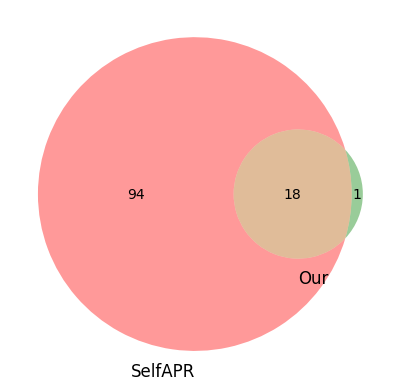

In [6]:
#Import libraries
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted, venn3
from matplotlib import pyplot as plt

def compare_selfapr(selfapr_path, path):
    our_df = read_eval_d4j(path)
    our_fixed = set(get_fixed(our_df))
    selfapr_df = pd.read_csv(selfapr_path, delimiter=';')
    selfapr_fixed = set()
    
    intersection = []
    intersection_list = []
    for index, row in selfapr_df.iterrows():
        new_selfapr_fixes = set(filter(lambda x: x != "", row["Repaired Bugs"].split(",")))
        inter = new_selfapr_fixes.intersection(our_fixed)
        intersection += [len(inter)]
        intersection_list += [inter]
        selfapr_fixed.update(new_selfapr_fixes)
    selfapr_df["Intersection"] = intersection
    selfapr_df["Intersection Repaired Bugs"] = intersection_list
    
    venn2([selfapr_fixed, our_fixed], ("SelfAPR", "Our"))
    
    # Compute SelfAPR bugs for reproduction
    pids = set()
    bugs = {}
    for x in selfapr_fixed:
        pid, bid = x.split("-")[0], int(x.split("-")[1])
        pids.add(pid)
        if pid in bugs:
            bugs[pid].add(bid)
        else:
            bugs[pid] = set([bid])
    
    print(pids)
    print(bugs)
    
    print("Fixed by SelfAPR only: " + str(selfapr_fixed - our_fixed))
    print("Fixed by both: " + str(selfapr_fixed.intersection(our_fixed)))
    print("Fixed by us only: " + str(our_fixed - selfapr_fixed))
    return selfapr_df

compare_selfapr("selfapr_fixed.csv", "experiments/defects4j_selfapr/round0/fixer/eval_defects4j_bw_100.json")

In [10]:
entries = []

d4j_path = "experiments/defects4j_selfapr/round0/fixer/eval_defects4j_bw_100.json"
bears_path = "experiments/defects4j_selfapr/round0/fixer/eval_bears_bw_100.json"
cb = "N/A"
tb = get_number_fixed(read_eval_d4j(bears_path))
cd = "N/A" #get_number_compile(read_eval_d4j(d4j_path))
td = get_number_fixed(read_eval_d4j(d4j_path))
entries += [get_table_entry(100, "", "round0", "", "", "", "x", cb, tb, cd, td)]

d4j_path = "experiments/defects4j_buglab/round0/fixer/eval_defects4j_bw_100.json"
bears_path = "experiments/defects4j_buglab/round0/fixer/eval_bears_bw_100.json"
cb = "N/A"
tb = get_number_fixed(read_eval_d4j(bears_path))
cd = "N/A" #get_number_compile(read_eval_d4j(d4j_path))
td = get_number_fixed(read_eval_d4j(d4j_path))
entries += [get_table_entry(100, "", "round0", "", "", "x", "", cb, tb, cd, td)]

d4j_path = "experiments/defects4j_buglab/round1-nocritic/part2/fixer/eval_defects4j_bw_100.json"
bears_path = "experiments/defects4j_buglab/round1-nocritic/part2/fixer/eval_bears_bw_100.json"
cb = "N/A"
tb = get_number_fixed(read_eval_d4j(bears_path))
cd = "N/A" #get_number_compile(read_eval_d4j(d4j_path))
td = get_number_fixed(read_eval_d4j(d4j_path))
entries += [get_table_entry(100, "", "round1-nocritic", "", "", "x", "", cb, tb, cd, td)]

d4j_path = "experiments/defects4j_buglab/round1-compiler/part2/fixer/eval_defects4j_bw_100.json"
bears_path = "experiments/defects4j_buglab/round1-compiler/part2/fixer/eval_bears_bw_100.json"
cb = "N/A"
tb = get_number_fixed(read_eval_d4j(bears_path))
cd = "N/A" #get_number_compile(read_eval_d4j(d4j_path))
td = get_number_fixed(read_eval_d4j(d4j_path))
entries += [get_table_entry(100, "", "round1-compiler", "", "", "x", "", cb, tb, cd, td)]

#d4j_path = "experiments/defects4j_buglab/round1-tests/part2/fixer/eval_defects4j_bw_100.json"
#bears_path = "experiments/defects4j_buglab/round1-tests/part2/fixer/eval_bears_bw_100.json"
#cb = "N/A"
#tb = get_number_fixed(read_eval_d4j(bears_path))
#cd = "N/A" #get_number_compile(read_eval_d4j(d4j_path))
#td = get_number_fixed(read_eval_d4j(d4j_path))
#entries += [get_table_entry(100, "", "round1-tests", "", "", "x", "", cb, tb, cd, td)]

#4j_path = "experiments/bears_buglab/round0/fixer/eval_defects4j_bw_100.json"
#ears_path = "experiments/bears_buglab/round0/fixer/eval_bears_bw_100.json"
#b = "N/A"
#b = get_number_fixed(read_eval_bears(bears_path))
#d = "N/A" #get_number_compile(read_eval_bears(d4j_path))
#d = get_number_fixed(read_eval_bears(d4j_path))
#ntries += [get_table_entry(100, "", "round0", "x", "", "", "", cb, tb, cd, td)]

#d4j_path = "experiments/bears_selfapr/round0/fixer/eval_defects4j_bw_100.json"
#bears_path = "experiments/bears_selfapr/round0/fixer/eval_bears_bw_100.json"
#cb = "N/A"
#tb = get_number_fixed(read_eval_bears(bears_path))
#cd = "N/A" #get_number_compile(read_eval_bears(d4j_path))
#td = get_number_fixed(read_eval_bears(d4j_path))
#entries += [get_table_entry(100, "", "round0", "", "x", "", "", cb, tb, cd, td)]

In [11]:
table = pd.json_normalize(data=entries)
table.columns = table.columns.str.split(".").map(tuple)
table

Hyper Parameters Training                                                    \
                      Bears         Defects4J         Critic            Round   
        Beam Width   BugLab SelfAPR    BugLab SelfAPR                           
0              100                                  x                  round0   
1              100                          x                          round0   
2              100                          x                 round1-nocritic   
3              100                          x                 round1-compiler   

        Testing                                                          
  Bears Compile  Bears Test Pass Defects4J Compile Defects4J Tests Pass  
                                                                         
0           N/A  1 / 250 (0.40%)               N/A     19 / 815 (2.33%)  
1           N/A  1 / 250 (0.40%)               N/A     14 / 815 (1.72%)  
2           N/A  3 / 250 (1.20%)               N/A     14 / 815 (1.72%)  
3           N/A  2 / 250 (0.80%)               N/A     18 / 815 (2.21%)